# Задача: Поиск сессионных аномалий

**Постановка задачи**: есть датасет, который был получен путем анализа временных задержек между
переходами пользователя по страницам портала K.
Необходимо найти такие сессии, в которых > 50% переходов не характерны истории
пользователя. Не характерными считаются те переходы, задержки которых в исследуемой
сессии сильно отличаются от его истории (например, в исследуемой сессии задержка
перехода равна 37 сек, тогда как в истории он вел себя так: [2, 1, 3, 4, 3, 1, 5]).

*Известно, что датасет включает в себя от 18% до 56% (в зависимости от метода
оценки) сессий, которые попадают под требуемый критерий (> 50% переходов не
характерны).

## Содержание:
* [1. Загрузка и описание данных](#download-bullet)
* [2. Предобработка данных](#preproc-bullet)
* [3. Разведочный анализ данных (EDA)](#eda-bullet)
* [4. Выбор и постоение модели (ML)](#ml-bullet)
* [5. Заключение](#final-bullet)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Загрузка и описание данных <a class="a" id="download-bullet"></a>

Датасет представляет собой список из кортежей, которые, в свою очередь, выглядят так:
( <идентификатор сессии>, <словарь переходов и их дельт в исследуемой сессии>, <словарь
переходов и их дельт в истории пользователя> )

Пример кортежа:
```
(
 'fe5dbbcea5ce7e2988b8c69bcfdfde8904aabc1f',
{
 '84,297': 46.8,
 '257,32': 7.2,
 },
{
 '257,32': [7.902, 15.038, 7.54, 8.0],
 '84,297': [4.896, 5.163, 9.1, 4.603, 6.373, 4.925, 7.3, 11.383]
}
)
```

In [2]:
dataset_dump = joblib.load('./dataset.dump')

In [3]:
current_session_df_struct = {
    'session_id': [],
    'transition_id': [],
    'delta': [],
    'previous_deltas': []
}

for session_id, current_session_dict, previous_sessions_dict in dataset_dump:

    for transition_id, transition_delta in current_session_dict.items():
        current_session_df_struct['session_id'].append(session_id)
        current_session_df_struct['transition_id'].append(transition_id)
        current_session_df_struct['delta'].append(transition_delta)

    for transition_id, transition_deltas_history in previous_sessions_dict.items():
        current_session_df_struct['previous_deltas'].append(tuple(transition_deltas_history))

session_df = pd.DataFrame(current_session_df_struct)

Полученный датафрейм имеют следующие поля:
- **session_id** - идентификатор сессии
- **transition_id** - идентификатор перехода
- **delta** - дельта, задержка между переходами пользователя по страницам портала N
- **previous_deltas** - tuple предыдущих задержек по ключам session_id и transition_id

In [4]:
session_df

,session_id,transition_id,delta,previous_deltas
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",7.334977,"(2.058, 1.789, 2.009, 1.996, 1.833, 1.88, 2.12..."
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"230,338",32.961081,"(6.886, 12.094000000000001, 10.171, 11.9490000..."
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"369,316",41.209562,"(9.129, 17.823, 15.675, 22.265, 12.75800000000..."
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"306,372",23.082700,"(2.243, 5.729, 5.504, 10.316, 3.342, 2.792, 7...."
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"381,191",1.474923,"(4.811, 2.04, 2.594, 3.573, 2.848, 3.496, 3.31..."
...,...,...,...,...
9983,f7e19157e9c4e0b9bf77b16588e3961fe4b0e2d9,"15,340",32.692865,"(21.935, 14.847000000000001, 16.773, 10.940000..."
9984,f7e19157e9c4e0b9bf77b16588e3961fe4b0e2d9,"238,174",31.247157,"(6.388999999999999, 9.144, 7.828, 4.976, 4.781..."
9985,9a50c8a873a65b2b15d3b8d52b9dd9de0559916a,"117,310",52.495072,"(2.08, 1.696, 1.915, 3.071, 3.415, 20.14200000..."
9986,9a50c8a873a65b2b15d3b8d52b9dd9de0559916a,"231,95",28.019961,"(3.277, 17.86, 1.681, 31.049, 24.0039999999999..."


# 2. Предобработка данных <a class="a" id="preproc-bullet"></a>

Перед началом работы убедимся в корректности типов данных, отсутствии пропусков и дубликатов.

In [5]:
session_df.info()
print('\n\nНаличие пустых строк:')
session_df[(session_df.session_id == '') & (session_df.transition_id == '')]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9988 entries, 0 to 9987
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   session_id       9988 non-null   object 
 1   transition_id    9988 non-null   object 
 2   delta            9988 non-null   float64
 3   previous_deltas  9988 non-null   object 
dtypes: float64(1), object(3)
memory usage: 312.2+ KB


Наличие пустых строк:


,session_id,transition_id,delta,previous_deltas


Типы данных загрузились **корректно**: дельта имеет численный тип с плавающей точкой, строковое представление идентификаторов сессии и перехода для исследования подходят. Null значения и пустые строки **отсутствуют**.

In [6]:
s_df = session_df.drop_duplicates().reset_index(drop=True)
s_df

,session_id,transition_id,delta,previous_deltas
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",7.334977,"(2.058, 1.789, 2.009, 1.996, 1.833, 1.88, 2.12..."
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"230,338",32.961081,"(6.886, 12.094000000000001, 10.171, 11.9490000..."
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"369,316",41.209562,"(9.129, 17.823, 15.675, 22.265, 12.75800000000..."
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"306,372",23.082700,"(2.243, 5.729, 5.504, 10.316, 3.342, 2.792, 7...."
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"381,191",1.474923,"(4.811, 2.04, 2.594, 3.573, 2.848, 3.496, 3.31..."
...,...,...,...,...
6418,22ef429533bb3d753379b516d4da11821dd0413c,"348,300",18.133641,"(2.251, 9.376999999999999, 3.17, 3.002, 3.1149..."
6419,4fa67f1265d138de3a014db126293aac7cfe8805,"48,171",185.366250,"(69.358, 47.726, 58.403000000000006, 29.442, 1..."
6420,4fa67f1265d138de3a014db126293aac7cfe8805,"127,258",5.048211,"(84.076, 57.335, 73.09, 41.345, 20.614, 20.691..."
6421,4fa67f1265d138de3a014db126293aac7cfe8805,"212,128",41.373050,"(14.718, 9.609, 5.478, 11.903, 7.186, 12.843, ..."


Было выявлено и удалено **3566** продублированных строк. Далее будем использовать s_df (ранее session_df) для краткости.

Распарсим колонку previous_deltas и создадим датафрейм с предыдущими дельтами h_df (history df):

In [7]:
tmp_frames = []
%time
for i in s_df.index:
    for j in s_df['previous_deltas'][i]:
        tmp_frames.append(pd.DataFrame([[s_df.iloc[i,0], s_df.iloc[i,1], j]], 
                                       columns=['session_id', 'transition_id', 'delta']))
h_df = pd.concat(tmp_frames, ignore_index=True)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


Датафрейм h_df имеет структуру, аналогичную s_df.

In [8]:
h_df

,session_id,transition_id,delta
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.058
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.789
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.009
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.996
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.833
...,...,...,...
168602,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.608
168603,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.323
168604,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.295
168605,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.034


# 3. Разведочный анализ данных (EDA) <a class="a" id="eda-bullet"></a>

Рассмотрим, с каким числом дельт на транзакцию нам придется работать:

In [9]:
h_df.groupby(['session_id', 'transition_id'], as_index=False).count().describe()

,delta
count,6423.000000
mean,26.250506
std,8.043114
min,16.000000
25%,20.000000
50%,25.000000
75%,30.000000
max,123.000000


In [10]:
def plotting_of(target_transactions, plot_type='hist', df=h_df):
    transaction_count = len(target_transactions)
    n_rows = transaction_count // 2 if transaction_count % 2 == 0 else transaction_count // 2 + 1
    fig, ax = plt.subplots(n_rows, 2, figsize=(15,12))

    for i, transaction in enumerate(target_transactions):
        tmp = df[df.transition_id == transaction].delta
        row = i // 2
        col = i % 2
        ax[row, col].set_title(f'{transaction} - Median: {round(tmp.median(), 2)}')
        ax[row, col].set_ylabel('Count')
        if plot_type == 'hist':
            ax[row, col].hist(tmp, bins=20)
        elif plot_type == 'boxplot':
            ax[row, col].boxplot(tmp, vert=False)

Для лучшего понимания следует рассматривать данные с большой историей дельт:

In [11]:
h_df.groupby(['session_id', 'transition_id'], as_index=False) \
                               .count() \
                               .rename(columns={'delta': 'deltas_count'}) \
                               .query('60 <= deltas_count <= 100').head()

,session_id,transition_id,deltas_count
816,2491991e0c2b3ea58ff0f92851ec4af9133a2ca1,"262,92",63
974,2a261e73a4b5d5eb8b25a997f6d1edcb0e811f6c,"130,164",62
1277,36740e782a458ebcab9f14ae3a8a5f19d04d0e41,"91,69",61
1418,3bd7c32b3c79dd85151c6588a929609c0b214c0b,"97,336",67
3371,833f0bbd72703484d9f12f9c3ef72eb1cc936b88,"118,35",83


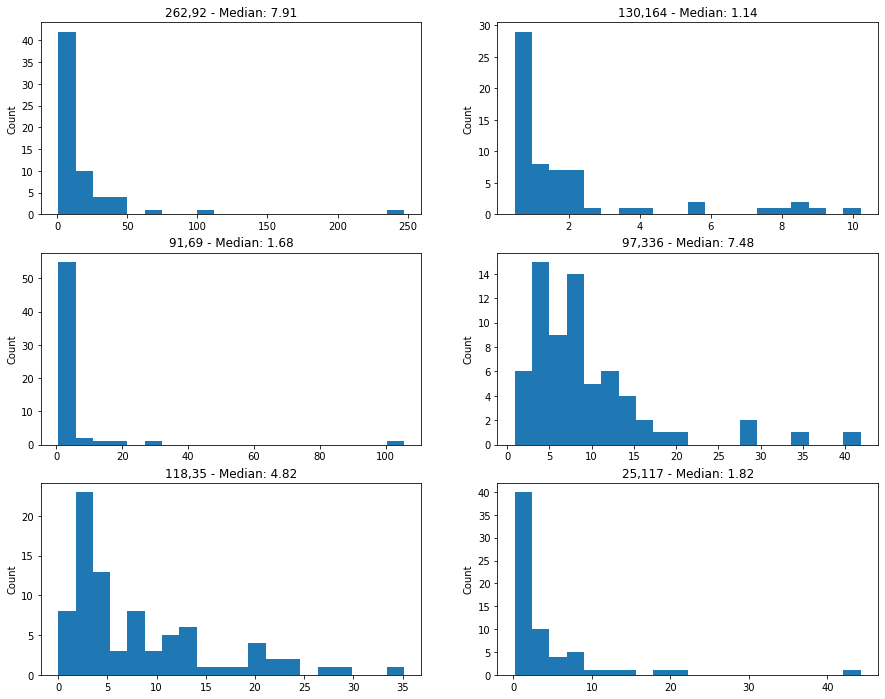

In [12]:
rich_transaction_samples = h_df.groupby(['session_id', 'transition_id'], as_index=False) \
                               .count() \
                               .rename(columns={'delta': 'deltas_count'}) \
                               .query('60 <= deltas_count <= 100') \
                               .transition_id.values

plotting_of(rich_transaction_samples[0:6])

На гистограммах наглядно видно, что датасет h_df загрязнен выбросами. ***При рассмотрении задачи поиска аномалий имеет место два варианта обучающих выборок***:
- Использование данных с выбросами
- Чистка обучающей выборки от выбросов, тем самым преобразуя задачу поиска аномалий к поиску новизны

Для работы с такими данными нам нужен статистический метод, способный действовать в условиях выбросов - медиана. Так же смотря на гистограммы, закрадывается сомнение о нормальности распределения, оно похоже на геометрическое или Пуассона. Поэтому находим, что [хорошей статистикой для суммирования выборки негауссовых распределений данных является Interquartile Range, или IQR для краткости.](https://www.machinelearningmastery.ru/how-to-use-statistics-to-identify-outliers-in-data/) [Межквартильный метод](https://en.wikipedia.org/wiki/Outlier#Peirce's_criterion) (заборы Тьюки) может использоваться для определения выбросов путем определения пределов значений выборки, которые являются фактором К IQR ниже 25-го процентиля или выше 75-го процентиля. Общее значение для фактора К это значение 1,5. Коэффициент k, равный 3 или более, можно использовать для определения значений, которые являются экстремальными выбросами.

In [13]:
def histboxplots_of(target_session, transaction, max_delta=None, min_delta=0, h_df=h_df):
    if max_delta:
        tmp = h_df[(h_df.session_id == target_session) \
                   & (h_df.transition_id == transaction) \
                   & (h_df.delta <= max_delta) \
                   & (h_df.delta >= min_delta)]
    else:
        tmp = h_df[(h_df.session_id == target_session) & (h_df.transition_id == transaction)]
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    fig.suptitle('Transaction ' + transaction)
    #hist
    ax[0].set_ylabel('count')
    ax[0].set_xlabel('delta')
    ax[0].hist(tmp.delta, bins=15)
    #lineplot
    ax[1].set_xlabel('delta')
    ax[1].boxplot(tmp.delta, vert=False)
    print(tmp.describe())

Выберем один из переходов с большой историей:

In [14]:
#from numpy import percentile
from scipy.stats import iqr, scoreatpercentile as percentile

data = h_df[(h_df.session_id == 'b6be5e13e175c5113c6072038f509c0d5a390708') & (h_df.transition_id == '13,121')].delta
# вспоминаем как считается межквартильный метод
q25, q75 = percentile(data, 25), percentile(data, 75)
custom_iqr = q75 - q25
print(f'Percentiles: 25th={q25}, 75th={q75}, IQR={custom_iqr}')

cut_off = iqr(data) * 3
lower, upper = q25 - cut_off, q75 + cut_off
print(lower, ' - ', upper)

Percentiles: 25th=1.0, 75th=4.0, IQR=3.0
-8.0  -  13.0


           delta
count  72.000000
mean    4.719750
std    10.092428
min     0.580000
25%     1.000000
50%     2.000000
75%     4.000000
max    77.000000


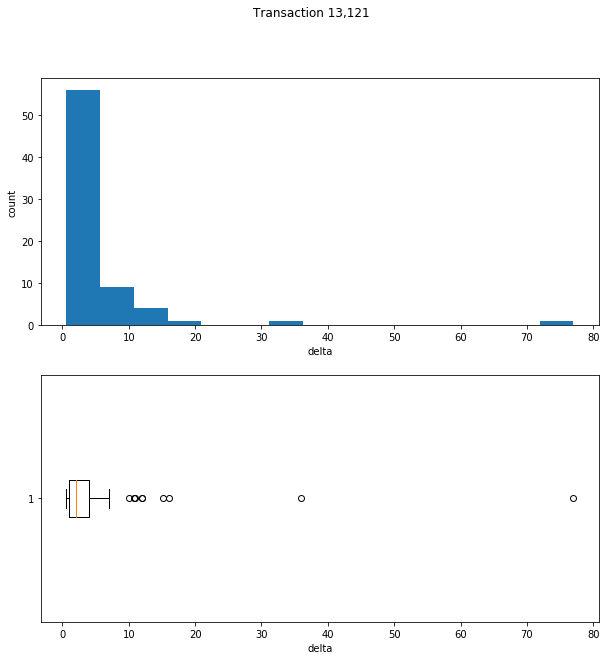

In [15]:
histboxplots_of(target_session='b6be5e13e175c5113c6072038f509c0d5a390708', transaction='13,121')

            delta
count   19.000000
mean    44.538684
std     22.886423
min     16.524000
25%     32.128500
50%     38.245000
75%     49.802000
max    110.536000


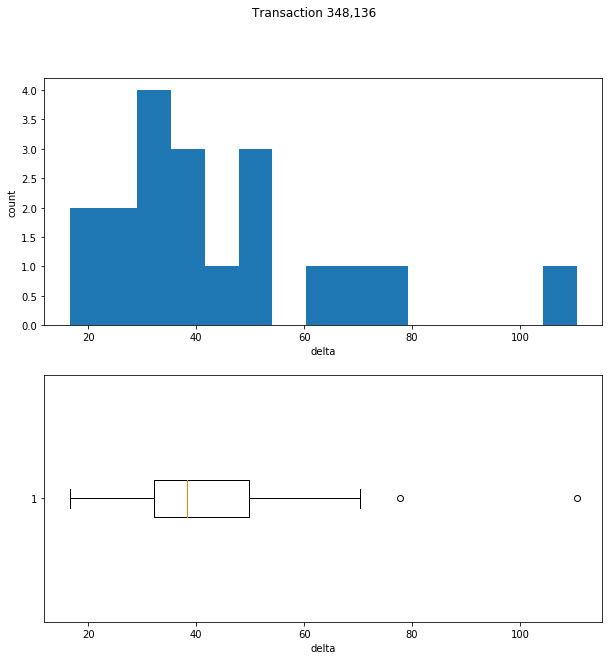

In [16]:
histboxplots_of(target_session='ffba58386f77f9616685b1558613aba9a9cfacce', transaction='348,136')

In [17]:
h_df[h_df.transition_id == '348,136']

,session_id,transition_id,delta
25204,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",35.045
25205,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",50.314
25206,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",63.836
25207,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",38.245
25208,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",77.703
25209,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",110.536
25210,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",49.290
25211,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",21.739
25212,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",40.939
25213,ffba58386f77f9616685b1558613aba9a9cfacce,"348,136",35.785


           delta
count  68.000000
mean    2.876647
std     2.892809
min     0.580000
25%     1.000000
50%     1.655500
75%     3.335750
max    12.000000


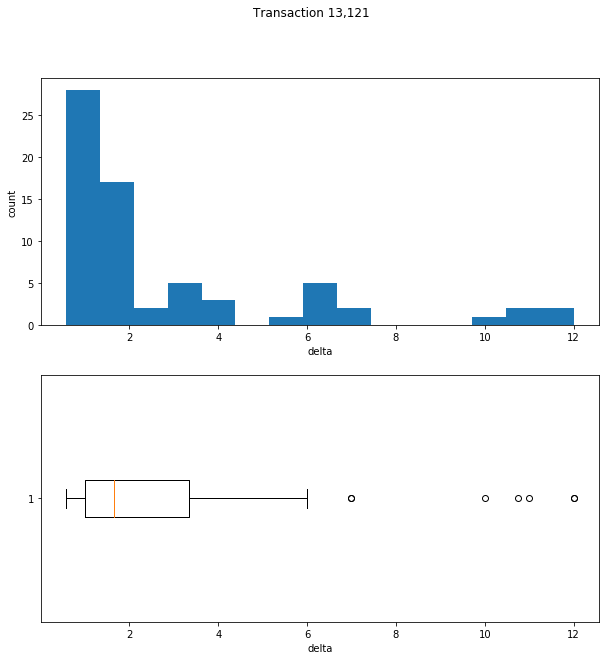

In [18]:
histboxplots_of(target_session='b6be5e13e175c5113c6072038f509c0d5a390708', transaction='13,121', max_delta=13)

In [19]:
s_df[(s_df.session_id == 'b6be5e13e175c5113c6072038f509c0d5a390708') & (s_df.transition_id == '13,121')]

,session_id,transition_id,delta,previous_deltas
3257,b6be5e13e175c5113c6072038f509c0d5a390708,"13,121",43.851811,"(0.838, 1.278, 1.569, 1.325, 1.433, 1.068, 15...."


Видим, что в произвольной сессии переход оказался нехарактерным. Проведем аналогичные действия со всем датасетом и сопоставим интервалы с датафреймом текущих сессий.

In [20]:
# функции для вычисления границ межквартильным методом
def iqr_min(data, k=3):
    q25, q75 = percentile(data, 25), percentile(data, 75)
    cut_off = iqr(data) * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower

def iqr_max(data, k=3):
    q25, q75 = percentile(data, 25), percentile(data, 75)
    cut_off = iqr(data) * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return upper

In [21]:
important_columns_df = h_df.groupby(['session_id', 'transition_id'], as_index=False) \
                           .delta.agg({'count_before': 'count',
                                       'median': 'median',
                                       'lower_limit': (lambda x: iqr_min(x)),
                                       'upper_limit': (lambda x: iqr_max(x))})
important_columns_df

,session_id,transition_id,count_before,median,lower_limit,upper_limit
0,001125a9c99911424defb45b6984e6cf53676e19,"10,88",20,4.7025,-8.87350,19.73375
1,001125a9c99911424defb45b6984e6cf53676e19,"112,260",26,12.5875,-23.14500,52.28700
2,001125a9c99911424defb45b6984e6cf53676e19,"133,242",22,14.9925,-27.92650,60.92275
3,001125a9c99911424defb45b6984e6cf53676e19,"195,202",20,8.5580,-18.47450,37.65325
4,001125a9c99911424defb45b6984e6cf53676e19,"212,332",20,8.2305,-12.49275,27.83775
...,...,...,...,...,...,...
6418,ffafff12cf5a0c4741eb3253f20bbdacd43d2c4b,"91,383",42,3.6650,-11.68075,22.57375
6419,ffba58386f77f9616685b1558613aba9a9cfacce,"173,378",16,5.5485,-21.39350,37.42050
6420,ffba58386f77f9616685b1558613aba9a9cfacce,"245,314",19,8.2390,-21.78750,42.47950
6421,ffba58386f77f9616685b1558613aba9a9cfacce,"290,210",25,4.8910,-15.30600,25.80500


In [22]:
s_df = pd.merge(s_df, important_columns_df, on=['session_id','transition_id'], how='outer').drop(columns='previous_deltas')

In [23]:
s_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",7.334977,26,2.0925,-1.47850,6.32825
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"230,338",32.961081,34,11.7335,-20.93375,41.74600
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"369,316",41.209562,28,20.6080,-16.76850,61.10475
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"306,372",23.082700,44,3.5040,-5.40775,13.78625
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"381,191",1.474923,18,2.4520,-2.57125,7.57875
...,...,...,...,...,...,...,...
6418,22ef429533bb3d753379b516d4da11821dd0413c,"348,300",18.133641,24,4.9865,-13.44050,25.28525
6419,4fa67f1265d138de3a014db126293aac7cfe8805,"48,171",185.366250,32,20.0000,-95.09800,154.21400
6420,4fa67f1265d138de3a014db126293aac7cfe8805,"127,258",5.048211,19,36.0000,-60.21650,140.83050
6421,4fa67f1265d138de3a014db126293aac7cfe8805,"212,128",41.373050,20,9.8400,-11.22475,30.96250


In [24]:
iqr3_condition = (s_df.lower_limit <= s_df.delta) & (s_df.delta <= s_df.upper_limit)
s_df['iqr3'] = iqr3_condition.astype(int)

In [25]:
s_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr3
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",7.334977,26,2.0925,-1.47850,6.32825,0
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"230,338",32.961081,34,11.7335,-20.93375,41.74600,1
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"369,316",41.209562,28,20.6080,-16.76850,61.10475,1
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"306,372",23.082700,44,3.5040,-5.40775,13.78625,0
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"381,191",1.474923,18,2.4520,-2.57125,7.57875,1
...,...,...,...,...,...,...,...,...
6418,22ef429533bb3d753379b516d4da11821dd0413c,"348,300",18.133641,24,4.9865,-13.44050,25.28525,1
6419,4fa67f1265d138de3a014db126293aac7cfe8805,"48,171",185.366250,32,20.0000,-95.09800,154.21400,0
6420,4fa67f1265d138de3a014db126293aac7cfe8805,"127,258",5.048211,19,36.0000,-60.21650,140.83050,1
6421,4fa67f1265d138de3a014db126293aac7cfe8805,"212,128",41.373050,20,9.8400,-11.22475,30.96250,0


Таким образом мы получили колонку iqr3 - принадлежность интервалу. Теперь рассмотрим процентное соотношение для каждой сессии и внесем результат датафрейм  y_results_df c итоговой классификацией.

In [26]:
s_df.groupby('session_id').iqr3.value_counts(normalize=True).unstack(level=1)

iqr3,0,1
session_id,,
001125a9c99911424defb45b6984e6cf53676e19,0.125000,0.875000
0012e4f1dc0e5920644dc5eed874ce6baa7e25d7,0.500000,0.500000
006e9c3a82f814fa415bf832e346c8b2fb2f1c9f,NaN,1.000000
0090d1eadb0ffd834f02eeeb1634f1919e016dfc,0.500000,0.500000
00a84d7c02fa639f91c4cc532370f2d071612576,0.375000,0.625000
...,...,...
fe2ef495a1152561572949784c16bf23abb28057,0.666667,0.333333
feef930093fe07af383a9b8a7c02d0547d6f3f1e,0.500000,0.500000
ff928232983f14781fbfc06bfb59b172e53b65dd,0.100000,0.900000


In [27]:
s_results_df = pd.DataFrame(s_df.groupby('session_id').iqr3 \
                             .value_counts(normalize=True) \
                             .unstack(level=1)[1])
s_results_df = s_results_df.fillna(0) \
                          .rename(columns={1: 'pass_iqr3'})

In [28]:
s_results_df[s_results_df.pass_iqr3 == 0.5]

,pass_iqr3
session_id,
0012e4f1dc0e5920644dc5eed874ce6baa7e25d7,0.5
0090d1eadb0ffd834f02eeeb1634f1919e016dfc,0.5
0de7f57bd4db22d7e4a43004aea93b1f0a484259,0.5
0e0e4f17d11f22e6b6b1f898113b39806fca13b0,0.5
137d22929d35f70072157667115aebbcd3f81530,0.5
...,...
f37062d9a65543a46f2ba13299ba77a370a1c4eb,0.5
fa755791d0509bb06ae715a2072de724815ed84d,0.5
fce05725d6c820b2419ae65bca09f76d49d1338a,0.5


Возникла ситуация, при которой 97 пользователей имеют **ровно** половину подозрительных сессий. Полагая, что в вопросах безопасности важнее recall, данные пользователи будут отнесены к аномалиям.

In [29]:
# round округлит 0.5 в 0
s_results_df = s_results_df.round()

In [30]:
print(s_results_df.pass_iqr3.value_counts(normalize=True))
print(s_results_df.pass_iqr3.value_counts())

1.0    0.65081
0.0    0.34919
Name: pass_iqr3, dtype: float64
1.0    643
0.0    345
Name: pass_iqr3, dtype: int64


Таким образом межквартильным метдом 35% сессий были классифицированы как нехарактерные.

**Почистим датафрейм h_df**

In [31]:
h_df = pd.merge(h_df, important_columns_df, on=['session_id','transition_id'], how='outer')

In [32]:
h_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.058,26,2.0925,-1.47850,6.32825
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.789,26,2.0925,-1.47850,6.32825
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.009,26,2.0925,-1.47850,6.32825
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.996,26,2.0925,-1.47850,6.32825
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.833,26,2.0925,-1.47850,6.32825
...,...,...,...,...,...,...,...
168602,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.608,38,1.2135,-0.51675,3.30700
168603,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.323,38,1.2135,-0.51675,3.30700
168604,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.295,38,1.2135,-0.51675,3.30700
168605,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.034,38,1.2135,-0.51675,3.30700


In [33]:
h_df['iqr_pred'] = (h_df.delta > h_df.upper_limit) | (h_df.delta < h_df.lower_limit)

In [34]:
h_df['iqr_pred'] = h_df.iqr_pred.replace((False, True), ('inlier', 'outlier'))

In [35]:
clear_h_df = h_df[h_df.iqr_pred == 'inlier']

In [36]:
clear_h_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr_pred
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.058,26,2.0925,-1.47850,6.32825,inlier
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.789,26,2.0925,-1.47850,6.32825,inlier
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.009,26,2.0925,-1.47850,6.32825,inlier
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.996,26,2.0925,-1.47850,6.32825,inlier
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.833,26,2.0925,-1.47850,6.32825,inlier
...,...,...,...,...,...,...,...,...
168602,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.608,38,1.2135,-0.51675,3.30700,inlier
168603,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.323,38,1.2135,-0.51675,3.30700,inlier
168604,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.295,38,1.2135,-0.51675,3.30700,inlier
168605,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.034,38,1.2135,-0.51675,3.30700,inlier


In [37]:
168607 - 161392

7215

In [38]:
important_columns_df = clear_h_df.groupby(['session_id', 'transition_id'], as_index=False) \
                           .delta.agg({'iqr_count': 'count'})

In [39]:
s_df = pd.merge(s_df, important_columns_df[['session_id', 'transition_id', 'iqr_count']], on=['session_id','transition_id'], how='outer')

In [40]:
s_df['contamination'] = 1 - s_df.iqr_count / s_df.count_before

In [41]:
s_df.describe()

,delta,count_before,median,lower_limit,upper_limit,iqr3,iqr_count,contamination
count,6423.000000,6423.000000,6423.000000,6423.000000,6423.000000,6423.000000,6423.000000,6423.000000
mean,36.021915,26.250506,10.448193,-18.704770,42.140696,0.645804,25.127199,0.043046
std,45.406024,8.043114,8.797280,21.586869,36.774319,0.478306,7.793795,0.045126
min,0.002918,16.000000,0.206000,-313.454000,0.301000,0.000000,13.000000,0.000000
25%,10.576547,20.000000,4.158750,-24.921750,17.528250,0.000000,19.000000,0.000000
50%,23.365611,25.000000,8.002000,-12.571000,32.655500,1.000000,23.000000,0.038462
75%,46.338645,30.000000,14.144500,-5.558125,56.873375,1.000000,29.000000,0.064516
max,1112.107322,123.000000,107.563500,13.075250,483.204500,1.000000,113.000000,0.315789


Таким образом было извлечено 7215 выбросов из данных. Взглянем повторно на некоторые из переходов:

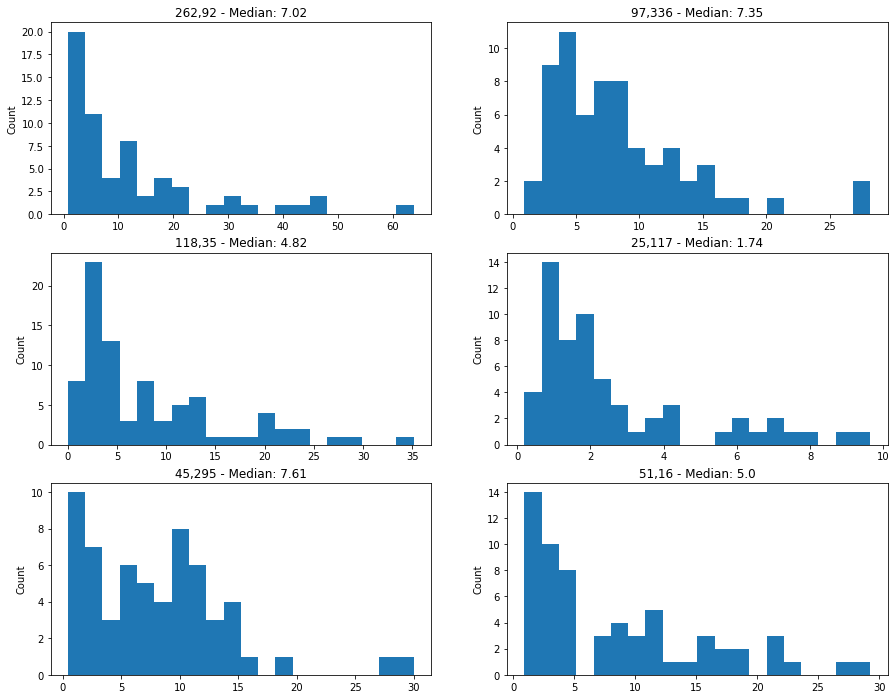

In [42]:
rich_transaction_samples = clear_h_df.groupby(['session_id', 'transition_id'], as_index=False) \
                               .count() \
                               .rename(columns={'delta': 'deltas_count'}) \
                               .query('60 <= deltas_count <= 100') \
                               .transition_id.values

plotting_of(rich_transaction_samples[0:6], df=clear_h_df)

Заметим, что данные стали заметно чище, но тем не менее имеют небольшие выбросы (переход 45,295). В случае необходимости этого можно избежать, уменьшив коэффициент К межквартильного метода с 3 до 1.5. Я же оставил коэффициент 3 из соображения, что более тонкую настройку удастся осуществить с помощью алгоритмо машинного обучения.

В дальнейшем для задачи детектирования аномалий будем использовать h_df, а для определения новизны clear_h_df.

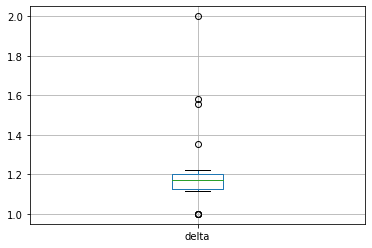

In [43]:
h_df[h_df.transition_id=='11,358'].boxplot(column=['delta'])

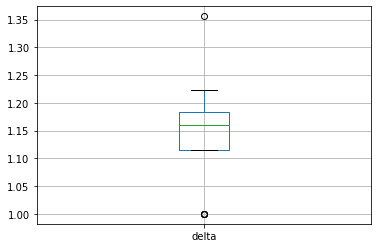

In [44]:
clear_h_df[clear_h_df.transition_id=='11,358'].boxplot(column=['delta'])

# 4. Выбор и постоение модели (ML) <a class="a" id="ml-bullet"></a>

**Популярные алгоритмы**

- Isolation Forest
- Эллипсоидальная аппроксимация данных
- ARIMA
- Метод опорных векторов (OneClassSVM)
- Метод К-средних (K-Means Clustering)
- Локальный фактор выбросов LOF (novelty=True)


Использование ARIMA на первый взгляд тоже не подходит для данной задачи, поскольку по одним лишь дельтам нельзя определить с какими интервалами во времени они происходили. Тем не менее алгоритм может хорошо проявить себя на реальных данных, выявляя контекстуальные аномалии.

Метод k-средних как мне кажется, подойдет лучше предыдущих, но, из-за наличия "большого" хвоста в распределениях, может использоваться только для поиска новизны . Проблемы возникнут при выборе числа кластеров и, возможно, при выборе алгоритмом начальных центров.

Эллипсоидальная аппроксимация данных — метод хорошо работает только на одномодальных данных, приближенных к нормальному распределению. Предполагая, что со временем распределение не меняется - хороший вариант для данной задачи. Интуитивно понятно, что чистые данные будут иметь распределение, приближенное к нормальному.

Так же в качестве задачи поиска новизны уместно будет выбрать [OneClassSVM](https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-cheat-sheet) или LOF с параметром novelty=True.

## Способ первый

Ввиду того, что не совсем понятно, как лучше определить порог при чистке данных исходя из условий задачи, воспользуемся методом Isolation Forest, который на удивление хорошо работает [даже с одномерными данными](https://dyakonov.org/2017/04/19/%D0%BF%D0%BE%D0%B8%D1%81%D0%BA-%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D0%B8%D0%B9-anomaly-detection/).

In [45]:
X = h_df[h_df.transition_id == '218,297']

In [46]:
X = X[['delta','transition_id']]

In [47]:
X

,delta,transition_id
35618,9.568,"218,297"
35619,7.865,"218,297"
35620,13.650,"218,297"
35621,10.552,"218,297"
35622,7.171,"218,297"
35623,13.551,"218,297"
35624,7.396,"218,297"
35625,9.626,"218,297"
35626,5.653,"218,297"
35627,6.530,"218,297"


In [48]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

In [49]:
clf = IsolationForest(random_state=0, n_estimators=500, contamination=0.25).fit_predict(X[['delta']])

In [50]:
el_clf = EllipticEnvelope(contamination=0.1).fit(X[['delta']])

In [51]:
el_clf.predict(X[['delta']])

array([ 1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1])

In [52]:
el_clf.predict(s_df[s_df.transition_id == '218,297'].delta.values.reshape(1, -1))

array([-1])

In [53]:
s_df[s_df.transition_id == '218,297'].delta.values

array([13.86984234])

In [54]:
clf

array([-1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1])

In [55]:
X['prediction'] = el_clf.predict(X[['delta']])



In [56]:
X.prediction = X['prediction'].replace((1, -1), ('inlier', 'outlier'))

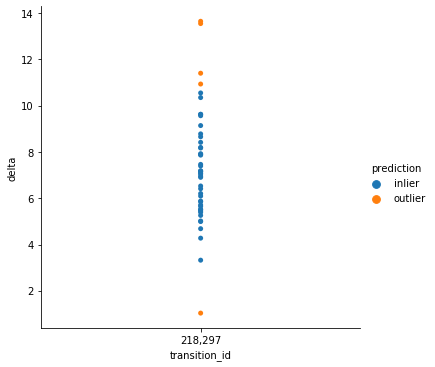

In [57]:
sns.catplot(y='delta', hue='prediction', x='transition_id', data=X, jitter=False)

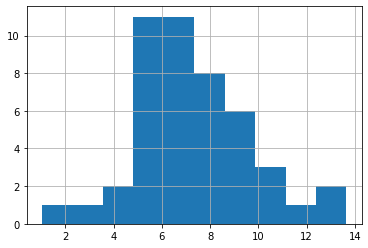

In [58]:
X.delta.hist()

При contamination=0.25 мы допускаем ложные срабатывания, но исключаем ошибки 2 рода.

In [59]:
X

,delta,transition_id,prediction
35618,9.568,"218,297",inlier
35619,7.865,"218,297",inlier
35620,13.650,"218,297",outlier
35621,10.552,"218,297",inlier
35622,7.171,"218,297",inlier
35623,13.551,"218,297",outlier
35624,7.396,"218,297",inlier
35625,9.626,"218,297",inlier
35626,5.653,"218,297",inlier
35627,6.530,"218,297",inlier


Таким бы образом строились модели для каждого перехода. На мой взгляд данный способ является трудоемким и подойдет на начальном этапе, но будет обладать плохой масштабируемостью с увеличением числа сессий. Хотелось бы получить одну универсальную модель взамен множеству.

## Способ второй


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a47966e90>]],
      dtype=object)

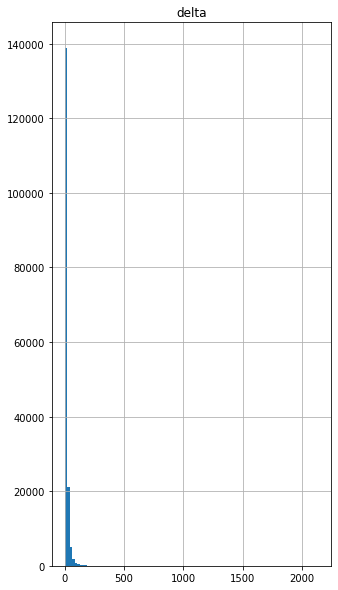

In [60]:
h_df[['delta']].hist(bins=100, figsize=(5,10))

На данном этапе эта гистограмма не имеет никакой ценности, поскольку данные не нормированы. Проблемой нормирования рассматриваемых данных является отсутствие информации о пограничных значениях. Предположим, что максимальное значение будет равно верхней границе межквартильного размаха по переходу, в то время как минимальное значение - нижняя граница в случае если она положительна, иначе - 0. В таком случае данные не будут расположены в интервале от 0 до 1, но, тем не менее, будут однозначно интерпритироваться, поскольку визуально их распределения похожи, не смотря на разницу главных статистик.

In [61]:
h_df['x'] = 0

In [62]:
h_df.describe()

,delta,count_before,median,lower_limit,upper_limit,x
count,168607.000000,168607.00000,168607.000000,168607.000000,168607.000000,168607.0
mean,13.910639,28.71452,10.145237,-18.688789,41.560953,0.0
std,20.964121,9.82626,8.370412,21.740227,36.384160,0.0
min,0.000000,16.00000,0.206000,-313.454000,0.301000,0.0
25%,3.870000,22.00000,4.146500,-24.604500,17.639500,0.0
50%,8.293000,27.00000,7.942500,-12.639000,32.334000,0.0
75%,16.731000,34.00000,13.749000,-5.918000,55.324000,0.0
max,2135.957000,123.00000,107.563500,13.075250,483.204500,0.0


In [63]:
h_df['lower_limit'] = h_df.lower_limit.where(h_df.lower_limit > 0, 0)

In [64]:
h_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr_pred,x
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.058,26,2.0925,0.0,6.32825,inlier,0
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.789,26,2.0925,0.0,6.32825,inlier,0
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.009,26,2.0925,0.0,6.32825,inlier,0
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.996,26,2.0925,0.0,6.32825,inlier,0
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.833,26,2.0925,0.0,6.32825,inlier,0
...,...,...,...,...,...,...,...,...,...
168602,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.608,38,1.2135,0.0,3.30700,inlier,0
168603,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.323,38,1.2135,0.0,3.30700,inlier,0
168604,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.295,38,1.2135,0.0,3.30700,inlier,0
168605,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.034,38,1.2135,0.0,3.30700,inlier,0


In [65]:
h_df['scaled_delta'] = (h_df.delta - h_df.lower_limit) / (h_df.upper_limit - h_df.lower_limit)

In [66]:
h_df.describe()

,delta,count_before,median,lower_limit,upper_limit,x,scaled_delta
count,168607.000000,168607.00000,168607.000000,168607.000000,168607.000000,168607.0,168607.000000
mean,13.910639,28.71452,10.145237,0.056604,41.560953,0.0,0.389012
std,20.964121,9.82626,8.370412,0.507008,36.384160,0.0,1.811062
min,0.000000,16.00000,0.206000,0.000000,0.301000,0.0,-0.548784
25%,3.870000,22.00000,4.146500,0.000000,17.639500,0.0,0.172294
50%,8.293000,27.00000,7.942500,0.000000,32.334000,0.0,0.291423
75%,16.731000,34.00000,13.749000,0.000000,55.324000,0.0,0.430881
max,2135.957000,123.00000,107.563500,13.075250,483.204500,0.0,635.066869


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a47cd8390>]],
      dtype=object)

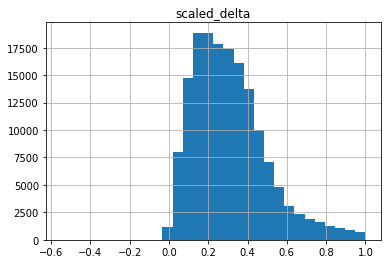

In [67]:
h_df[['scaled_delta']][(h_df.scaled_delta < 1)].hist(bins=30)

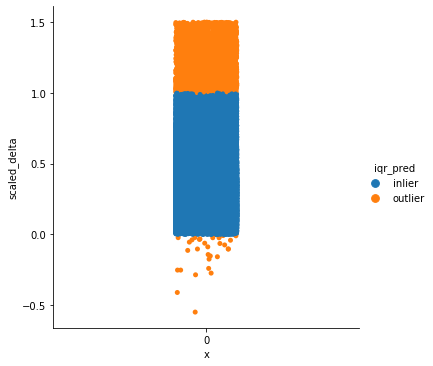

In [68]:
sns.catplot(y='scaled_delta', x='x', hue='iqr_pred', data=h_df[(h_df.scaled_delta < 1.5)], jitter=True)

In [69]:
h_df.iqr_pred.value_counts()

inlier     161392
outlier      7215
Name: iqr_pred, dtype: int64

In [70]:
clf = IsolationForest(random_state=0, n_estimators=1000,  contamination=0.2).fit_predict(h_df[['scaled_delta']])

In [71]:
h_df['IF_pred'] = clf
h_df['IF_pred'] = h_df.IF_pred.replace((1, -1), ('inlier', 'outlier'))

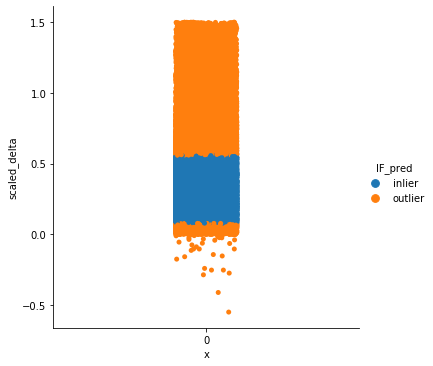

In [72]:
sns.catplot(y='scaled_delta', hue='IF_pred', x='x', data=h_df[(h_df.scaled_delta < 1.5)], jitter=True)

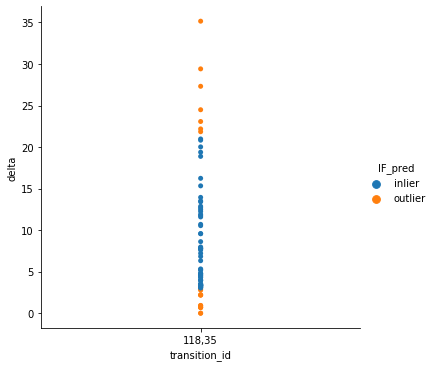

In [73]:
sns.catplot(y='delta', hue='IF_pred', x='transition_id', data=h_df[h_df.transition_id == '118,35'], jitter=False)

In [74]:
h_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr_pred,x,scaled_delta,IF_pred
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.058,26,2.0925,0.0,6.32825,inlier,0,0.325208,inlier
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.789,26,2.0925,0.0,6.32825,inlier,0,0.282701,inlier
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",2.009,26,2.0925,0.0,6.32825,inlier,0,0.317465,inlier
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.996,26,2.0925,0.0,6.32825,inlier,0,0.315411,inlier
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",1.833,26,2.0925,0.0,6.32825,inlier,0,0.289654,inlier
...,...,...,...,...,...,...,...,...,...,...,...
168602,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.608,38,1.2135,0.0,3.30700,inlier,0,0.788630,outlier
168603,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",2.323,38,1.2135,0.0,3.30700,inlier,0,0.702449,outlier
168604,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.295,38,1.2135,0.0,3.30700,inlier,0,0.391594,inlier
168605,4fa67f1265d138de3a014db126293aac7cfe8805,"257,2",1.034,38,1.2135,0.0,3.30700,inlier,0,0.312670,inlier


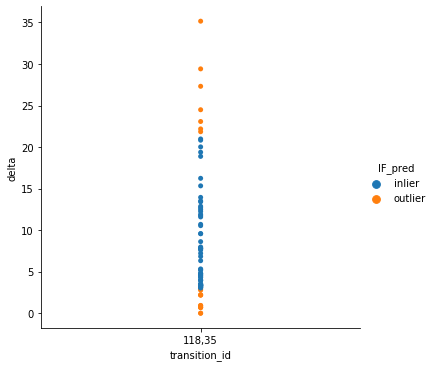

In [75]:
sns.catplot(y='delta', hue='IF_pred', x='transition_id', data=h_df[h_df.transition_id == '118,35'], jitter=False)

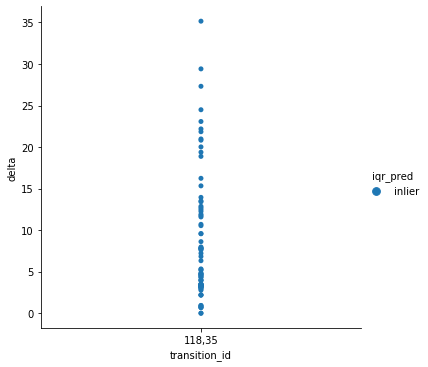

In [76]:
sns.catplot(y='delta', hue='iqr_pred', x='transition_id', data=h_df[h_df.transition_id == '118,35'], jitter=False)

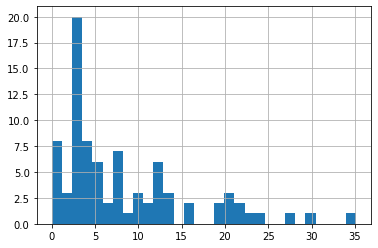

In [77]:
h_df[h_df.transition_id == '118,35'].delta.hist(bins=30)

Таким образом нам удалось разработать baseline модель для поставленной задачи. Загрязненность данных оценивал визуально, опираясь на результаты, полученные в предыдущей главе. Дальше можно рассуждать в разных направлениях, например отдельно обрабатывать переходы с маленькой историей, при организации пайплайн модели добавить возможность перерасчета межквартильного размаха и т.д.

Эвристика методом пристального взгляда: выбросы больше медианы идентифицировать по изолирующему лесу, а меньше медианы - по квартилям.

Тогда 'чистый' датасет для распозавания новизны будет выглядеть следующим образом:

In [78]:
h_df['iqr_IF_pred'] = pd.Series(h_df.IF_pred)

In [79]:
h_df['iqr_IF_pred'] = h_df.IF_pred.where(h_df.delta > h_df['median'], h_df.iqr_pred)

In [80]:
iqr_IF_inliers_df = h_df[h_df.iqr_IF_pred == 'inlier']

In [81]:
s_df[['transition_id','delta']]

,transition_id,delta
0,"323,188",7.334977
1,"230,338",32.961081
2,"369,316",41.209562
3,"306,372",23.082700
4,"381,191",1.474923
...,...,...
6418,"348,300",18.133641
6419,"48,171",185.366250
6420,"127,258",5.048211
6421,"212,128",41.373050


In [82]:
s_df

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr3,iqr_count,contamination
0,974ab4c974716eac64aa7fc9bfeed7ab06413819,"323,188",7.334977,26,2.0925,-1.47850,6.32825,0,24,0.076923
1,974ab4c974716eac64aa7fc9bfeed7ab06413819,"230,338",32.961081,34,11.7335,-20.93375,41.74600,1,32,0.058824
2,974ab4c974716eac64aa7fc9bfeed7ab06413819,"369,316",41.209562,28,20.6080,-16.76850,61.10475,1,28,0.000000
3,974ab4c974716eac64aa7fc9bfeed7ab06413819,"306,372",23.082700,44,3.5040,-5.40775,13.78625,0,43,0.022727
4,974ab4c974716eac64aa7fc9bfeed7ab06413819,"381,191",1.474923,18,2.4520,-2.57125,7.57875,1,18,0.000000
...,...,...,...,...,...,...,...,...,...,...
6418,22ef429533bb3d753379b516d4da11821dd0413c,"348,300",18.133641,24,4.9865,-13.44050,25.28525,1,24,0.000000
6419,4fa67f1265d138de3a014db126293aac7cfe8805,"48,171",185.366250,32,20.0000,-95.09800,154.21400,0,32,0.000000
6420,4fa67f1265d138de3a014db126293aac7cfe8805,"127,258",5.048211,19,36.0000,-60.21650,140.83050,1,19,0.000000
6421,4fa67f1265d138de3a014db126293aac7cfe8805,"212,128",41.373050,20,9.8400,-11.22475,30.96250,0,20,0.000000


In [83]:
s_df['lower_limit'] = s_df.lower_limit.where(s_df.lower_limit > 0, 0)

In [84]:
s_df['scaled_delta'] = (s_df.delta - s_df.lower_limit) / (s_df.upper_limit - s_df.lower_limit)

In [85]:
lof2_clf = LocalOutlierFactor(n_neighbors=80, novelty=True).fit(iqr_IF_inliers_df[['scaled_delta']])
s_df['LOF2_pred'] = lof2_clf.predict(s_df[['scaled_delta']])
s_df['LOF2_pred'] = s_df.LOF2_pred.replace((1, -1), ('inlier', 'outlier'))

In [86]:
s_df['x'] = 0

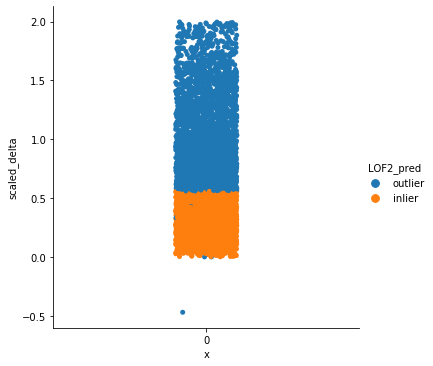

In [87]:
sns.catplot(y='scaled_delta', hue='LOF2_pred', x='x', data=s_df[s_df.scaled_delta < 2], jitter=True)

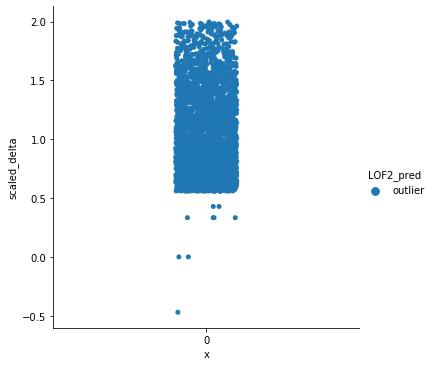

In [88]:
sns.catplot(y='scaled_delta', hue='LOF2_pred', x='x', data=s_df[(s_df.LOF2_pred == 'outlier') & (s_df.scaled_delta < 2)], jitter=True)

In [102]:
s_df[(s_df.LOF2_pred == 'outlier') & (s_df.scaled_delta < 0.5)]

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr3,iqr_count,contamination,scaled_delta,LOF2_pred,x
234,82517e6de979bb1ee47e35ec24261b2b26e30ae3,"249,28",0.002918,56,1.7015,0.000,15.07000,1,55,0.017857,0.000194,outlier,0
1810,17bd6629fe4cf6c24336c363ec3631d5d9090f05,"49,359",0.012196,16,2.7940,0.000,33.96025,1,16,0.000000,0.000359,outlier,0
3326,171d604483ec5a6107af501082ad43de71473452,"61,114",14.496454,34,11.9390,0.000,43.48150,1,34,0.000000,0.333394,outlier,0
3497,31fb9f38feb65b1accc25e0538d508d715d951bb,"6,58",12.998158,33,14.2930,0.000,30.32000,1,33,0.000000,0.428699,outlier,0
3623,f4669fc3bb951a59f8987c1d4441605a11666a90,"364,68",17.017713,24,13.2615,0.000,51.06100,1,24,0.000000,0.333282,outlier,0
4395,8639c2e8c44d79a5afaf095aa46f9c9231829b72,"40,308",9.132868,22,10.6495,0.000,27.40125,1,21,0.045455,0.333301,outlier,0
5682,85f4b8dd4455a2ae94ba703af789359f03ae71a6,"158,275",9.218144,19,4.6320,0.000,27.65450,1,19,0.000000,0.333333,outlier,0
5806,87ee54b1820f961fe68a462f7352b9215a965a43,"96,29",8.260400,27,4.6140,0.000,19.27050,1,26,0.037037,0.428655,outlier,0
5863,1d25caa86469e680b7dfceb94bfc822f1d1684a9,"44,314",0.701777,23,4.0000,2.384,5.96100,0,19,0.173913,-0.470289,outlier,0


Как мы видим, некоректная классификация встречается на маленьких выборках (<35)

Рассмотрим полученный результат на переходах с большой историей:

In [90]:
s_df[(s_df.count_before > 45) & (s_df.LOF2_pred == 'outlier')].head(10)

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr3,iqr_count,contamination,scaled_delta,LOF2_pred,x
10,7d1867122d9eafc204bc63acbd2f589ff9963d8e,"303,37",51.299541,46,17.5885,0.0,45.47525,0,44,0.043478,1.128076,outlier,0
13,611c3b4d6ea88f2a4b922d982b4acd2c17f7d8be,"293,147",46.149148,47,7.4280,0.0,34.89100,0,44,0.063830,1.322666,outlier,0
36,08a35293e09f508494096c1c1b3819edb9df50db,"113,142",100.903235,49,5.6570,0.0,26.66300,0,47,0.040816,3.784392,outlier,0
104,a561ae764b1317ef485b3aea95ac8072bf632c44,"366,291",132.446849,57,6.2290,0.0,34.03200,0,56,0.017544,3.891833,outlier,0
113,1ea03c9dd3948548dc036ab43305955ca21199c6,"154,375",43.686388,46,13.5200,0.0,73.22425,1,46,0.000000,0.596611,outlier,0
199,e5edc32eff2b7ede6f73bacba69cbf532b9e26df,"193,280",45.150757,51,9.2050,0.0,55.60950,1,50,0.019608,0.811925,outlier,0
233,82517e6de979bb1ee47e35ec24261b2b26e30ae3,"38,127",23.689530,55,1.6970,0.0,13.57000,0,49,0.109091,1.745728,outlier,0
234,82517e6de979bb1ee47e35ec24261b2b26e30ae3,"249,28",0.002918,56,1.7015,0.0,15.07000,1,55,0.017857,0.000194,outlier,0
286,c9d9149cb62c8106a8e0871fca54bb4f6e52f533,"377,164",171.731144,46,6.3780,0.0,26.80075,0,43,0.065217,6.407699,outlier,0
437,a2637870b7856ba0031050025ba59d77a61bb780,"341,191",30.659756,50,5.9125,0.0,32.76025,1,47,0.060000,0.935883,outlier,0


Соединим датасеты для иллюстрации того, как отработала данная комбинация алгоритмов.

In [91]:
transition_result_df = pd.DataFrame(h_df[['transition_id', 'delta', 'iqr_IF_pred', 'x']] \
                             .rename(columns = {'iqr_IF_pred':'prediction'}, inplace = False))

In [92]:
transition_result_df['delta_type'] = 'train'

In [93]:
tmp_df =  s_df[['transition_id', 'delta', 'LOF2_pred', 'x']].rename(columns = {'LOF2_pred':'prediction'})

In [94]:
tmp_df['delta_type'] = 'predict'

In [95]:
tmp_df

,transition_id,delta,prediction,x,delta_type
0,"323,188",7.334977,outlier,0,predict
1,"230,338",32.961081,outlier,0,predict
2,"369,316",41.209562,outlier,0,predict
3,"306,372",23.082700,outlier,0,predict
4,"381,191",1.474923,inlier,0,predict
...,...,...,...,...,...
6418,"348,300",18.133641,outlier,0,predict
6419,"48,171",185.366250,outlier,0,predict
6420,"127,258",5.048211,inlier,0,predict
6421,"212,128",41.373050,outlier,0,predict


In [96]:
transition_result_df = pd.concat([transition_result_df,tmp_df], ignore_index=True)

In [97]:
transition_result_df['x'] = 0

In [98]:
transition_result_df

,transition_id,delta,prediction,x,delta_type
0,"323,188",2.058000,inlier,0,train
1,"323,188",1.789000,inlier,0,train
2,"323,188",2.009000,inlier,0,train
3,"323,188",1.996000,inlier,0,train
4,"323,188",1.833000,inlier,0,train
...,...,...,...,...,...
175025,"348,300",18.133641,outlier,0,predict
175026,"48,171",185.366250,outlier,0,predict
175027,"127,258",5.048211,inlier,0,predict
175028,"212,128",41.373050,outlier,0,predict


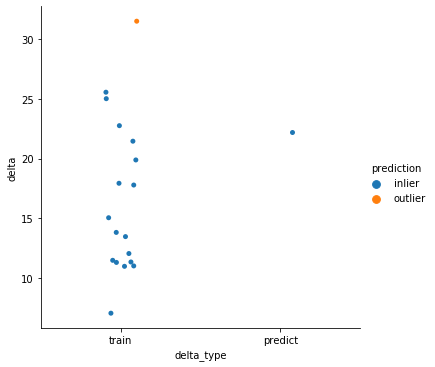

In [99]:
sns.catplot(y='delta', hue='prediction', x='delta_type', data=transition_result_df[transition_result_df.transition_id == '363,371'], jitter=True)


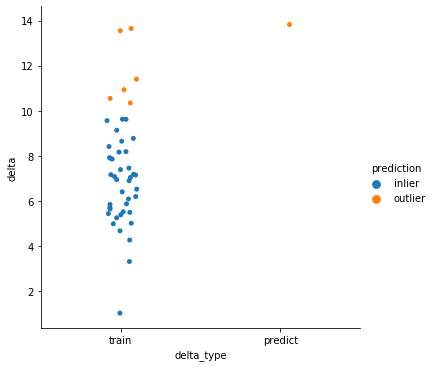

In [132]:
sns.catplot(y='delta', hue='prediction', x='delta_type', data=transition_result_df[transition_result_df.transition_id == '218,297'], jitter=True)


Теперь мы можем ответить на вопрос, какое число сессий выбранная модель классифицирует как подозрительные.

In [134]:
s_df.groupby('session_id').LOF2_pred.value_counts(normalize=True).unstack(level=1)

LOF2_pred,inlier,outlier
session_id,,
001125a9c99911424defb45b6984e6cf53676e19,0.625000,0.375000
0012e4f1dc0e5920644dc5eed874ce6baa7e25d7,0.300000,0.700000
006e9c3a82f814fa415bf832e346c8b2fb2f1c9f,1.000000,NaN
0090d1eadb0ffd834f02eeeb1634f1919e016dfc,0.250000,0.750000
00a84d7c02fa639f91c4cc532370f2d071612576,0.375000,0.625000
...,...,...
fe2ef495a1152561572949784c16bf23abb28057,NaN,1.000000
feef930093fe07af383a9b8a7c02d0547d6f3f1e,0.500000,0.500000
ff928232983f14781fbfc06bfb59b172e53b65dd,0.600000,0.400000


In [138]:
s_results_df['LOF2_pred'] = s_df.groupby('session_id').LOF2_pred \
                                .value_counts(normalize=True) \
                                .unstack(level=1)['inlier']
s_results_df['LOF2_pred'] = s_results_df['LOF2_pred'].fillna(0) \
                                                     .round()

In [137]:
print(s_results_df.LOF2_pred.value_counts(normalize=True))
print(s_results_df.LOF2_pred.value_counts())

0.0    0.770243
1.0    0.229757
Name: LOF2_pred, dtype: float64
0.0    761
1.0    227
Name: LOF2_pred, dtype: int64


Таким образом было выявлено, что 23% сессий являлись подозрительными. Рассмотрим некоторые сессии, предсказания модели и статистического метода которых отличаются.

In [139]:
s_results_df[(s_results_df.pass_iqr3) == 1 & (s_results_df.LOF2_pred == 0)]

,pass_iqr3,LOF2_pred
session_id,,
00a84d7c02fa639f91c4cc532370f2d071612576,1.0,0.0
016ec52ec25eabba4b988aeaab58eb7d962c47bd,1.0,0.0
02b1a4b2bd92d82a564ad9fca51573a3d56fd09d,1.0,0.0
0310477142171b7d67f2a1cd85c90a3b66be9c57,1.0,0.0
034695bdec797bfd7634c487374b598a67c47a5c,1.0,0.0
...,...,...
fb6d494b276da2b2006d4c43c170b94b45859d58,1.0,0.0
fbd76cc438da4443473bf1514bd474f82866914d,1.0,0.0
fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,1.0,0.0


In [143]:
s_df[s_df.session_id == 'fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1']

,session_id,transition_id,delta,count_before,median,lower_limit,upper_limit,iqr3,iqr_count,contamination,scaled_delta,LOF2_pred,x
4684,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"239,139",112.786593,24,25.1125,0.0,80.1540,0,23,0.041667,1.407124,outlier,0
4685,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"361,251",61.381259,25,7.5800,0.0,29.8960,0,21,0.160000,2.053160,outlier,0
4686,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"162,164",18.863533,22,3.4625,0.0,29.4165,1,20,0.090909,0.641257,outlier,0
4687,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"359,273",49.422551,21,6.5180,0.0,36.3190,0,19,0.095238,1.360791,outlier,0
4688,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"313,392",1.885436,21,1.4660,0.0,3.7850,1,21,0.000000,0.498134,inlier,0
4689,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"26,329",7.053022,23,2.7810,0.0,8.1630,1,23,0.000000,0.864023,outlier,0
4690,fc25f9cddc99d1f2cd5b50f21fb4a5b12f9bf0b1,"264,398",2.546322,21,1.0660,0.0,5.8410,1,21,0.000000,0.435939,inlier,0


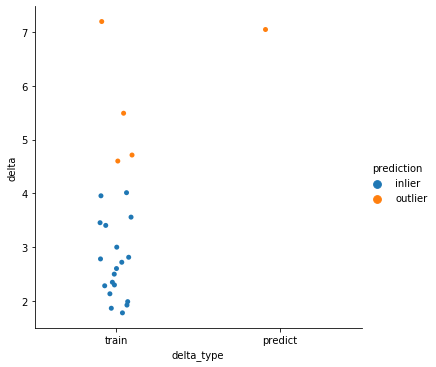

In [144]:
sns.catplot(y='delta', hue='prediction', x='delta_type', data=transition_result_df[transition_result_df.transition_id == '26,329'], jitter=True)


Выборочная сверка результатов с межквартильным интервалом показала, что постоенная модель позволяет получать более точные предсказания.

# Заключение <a class="a" id="final-bullet"></a>

В данной работе был разработана модель поиска аномалий в данных dataset.dump. Алгоритм заключается в обработке историй посещения страницы сайта путем нормирования данных и применения алгоритма IsolationForest. Преобразовав задачу к поиску новизны, был использован алгоритм  LOF для классификации текущей сессии. Полученное рещение имеет ряд таких недостатков, как предположение о статичности распределения для каждого перехода и потребность в более тонкой настройки в нижней границе выбросов.

Тем не менее, данная модель выгоднее первого рассмотренного варианта за счет отсутствия нужды обучать отдельные модели под каждый переход.